# Label Shuffle Experiment for Progressive Learning

The progressive learning package utilizes representation ensembling algorithms to sequentially learn a representation for each task and ensemble both old and new representations for all future decisions. 

Here, two complementary representation ensembling algorithms based on decision forests (Lifelong Forest) and deep networks (Lifelong Network) demonstrate forward and backward knowledge transfer of tasks on the CIFAR100 dataset with the labels shuffled. The experiment reproduces the benchmarking adversarial experiment ran in the paper "A General Approach to Progressive Learning" by Vogelstein, et al (2020). https://arxiv.org/pdf/2004.12908.pdf  

### Import necessary packages and modules

In [1]:
import numpy as np
import keras
from joblib import Parallel, delayed
from multiprocessing import Pool
from itertools import product

### Load CIFAR100 data 
We load the CIFAR100 dataset from Keras, and store it in a variable. The training and test partitions are concatenated into one variable called `data_x`. The data is obtained from https://keras.io/api/datasets/cifar100/ .

The label shuffle experiment randomly permutes the class labels within each task from task 2 to 9, rendering each of these tasks adversarial with regard to the first task. We show through this experiment that both L2F and L2N are invariant to class lable shuffling, and both demonstrate transfer.  

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()
data_x = np.concatenate([X_train, X_test])

### Define hyperparameters for the model and preprocess data
Running the cells below will define the hyperparameters the model, and preprocess the data. 

`model`: string storing the name of the chosen model of transformer. Choose between dnn (deep neural network) and uf (uncertainty forest).

Other hyperparameters of interest include the `num_points_per_task` and `shifts`, which decide the number of iterations of the algorithm. 

In [4]:
# Declare type of model
model = "uf"
num_points_per_task = 500

# Reshape the data 
if model == "uf":
    data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2] * data_x.shape[3]))
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

# Calculate number of slots based on num_points_per_task
slot_fold = range(int(5000 // num_points_per_task))
shifts = 2 # Number of shifts

df_list = [] # Initialize list that stores the results of validation

### Train the model and perform validation

#### run_parallel_exp: 
Wrapper method for the `LF_experiment` function which declares and trains the model, and performs validation with respect to the test data to compute the accuracy of the model at a particular iteration. The wrapper function is also used to configure GPU

`data_x`: The entire array containing the x values

`data_y`: The entire array containing the y values

`ntree`: Number of trees for Uncertainty Forest

`num_points_per_task`: Integer representing number of points per task

`slot`: Integer representing the slot that the model performs

`shift`: Integer representing the shift that the model performs

In [5]:
from label_shuffle_functions import run_parallel_exp

if model == "uf":
    shift_fold = range(1,shifts,1) # Number of shifts
    n_trees=[10] # Number of trees in UF
    iterable = product(n_trees,shift_fold,slot_fold)
    df_list = Parallel(n_jobs=-2,verbose=1)(
        delayed(run_parallel_exp)(
                data_x, data_y, ntree, model, num_points_per_task, slot=slot, shift=shift
                ) for ntree,shift,slot in iterable
                )
    
elif model == "dnn":
    # Perform shifts in parallel
    for slot in slot_fold:
        def perform_shift(shift):
            return run_parallel_exp(data_x, data_y, 0, model, num_points_per_task, slot=slot, shift=shift)
        
        shifts = range(1, shifts) # Number of shifts
        with Pool(7) as p:
            df_list.append(p.map(perform_shift, shifts))

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   8 out of  10 | elapsed:  6.3min remaining:  1.6min
[Parallel(n_jobs=-2)]: Done  10 out of  10 | elapsed:  6.3min finished


### Function to calculate backward transfer efficiency

The backward transfer efficiency of $f_n$ for task $t$ given $n$ 􏰁samples is 
$$BTE^t (f_n) := \mathbb{E} [R^t (f_n )/R^t (f_n)]$$

We say an algorithm (positive) backward transfers for task $t$ if and only if $BTE^t(f_n) > 1$, or if $\log BTE^t(f_n) > 0$. In other words, if 
$$BTE^t(f_n) > 1$$
then the algorithm has used data associated with new tasks to improve performance on previous tasks. 

#### calc_bte:
This is the list of parameters for calc_bte, the function used to calculate the btes of each fold and shift

`df_list`: List containing dataframes of training results 

`slots`: Integer representing number of slots 

`shifts`: Integer representing number of shifts 

`alg_name`: List containing names of algorithms 

`alg_no`: Integer containing the index of alg_name you wish to plot 

In [6]:
from label_shuffle_functions import calc_bte

slots = 10 # Number of slots

if model == "uf":
    alg_name = ['L2F']
elif model == "dnn":
    alg_name = ['L2N']
    
alg_no = 0

btes = calc_bte(df_list, slots, shifts, alg_name, alg_no)

### Plotting the backward transfer efficiency
Run cell to generate plot of backward transfer efficiency of the lifelong forest and lifelong network algorithm. We see that with both algorithms, a backward transfer efficiency greater than 1 is achieved, and the backward transfer efficiency also increases as more number of tasks are seen. 

#### plot_bte:
This is the list of parameters for plot_bte, the function used to plot the BTE

`alg_name`: List containing names of algorithms 

`alg_no`: Integer containing the index of alg_name you wish to plot 

`btes`: List containing the btes calculated from `calc_bte`


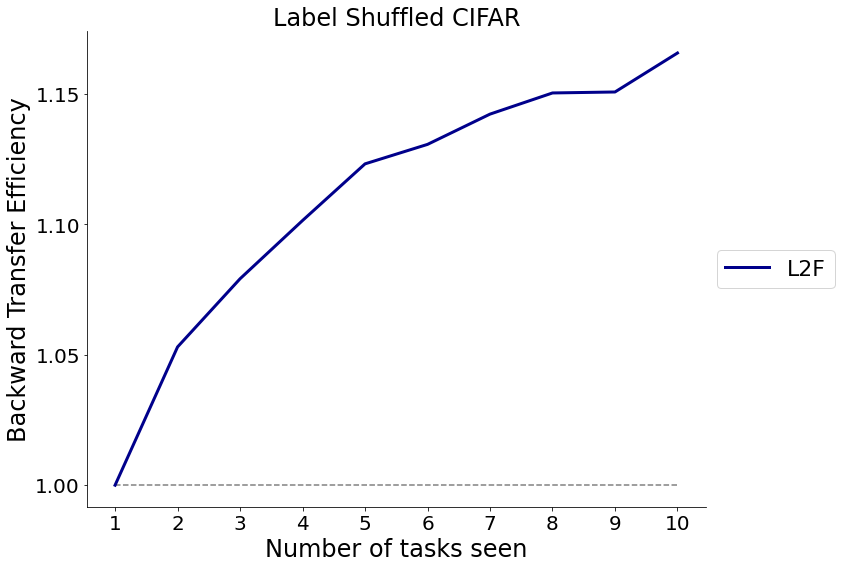

In [7]:
from label_shuffle_functions import plot_bte

plot_bte(alg_name, alg_no, btes)